# RBM(制約ボルツマンマシン)を試してみる
**今回は、[Restricted Boltzmann Machine features for digit classification](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)を参考にしてみます**  
ピクセル値が白い背景の黒度として解釈できるグレースケール画像データの場合(今回は手書きの数字認識)、  
ベルヌーイ制限付きボルツマンマシンモデル（BernoulliRBM）は、効果的な特徴抽出を行うことができます。  
  
データセットから潜在的な特徴を学習するため、  
各方向に1ピクセルづつシフトして学習用データを小さく撹乱させることにより、より多くのラベル付きデータを人工的に生成します。

今回の例は、BernoulliRBM特徴抽出器とLogisticRegression分類器を使用して  
分類パイプラインを構築する方法を示しています。モデル全体のハイパーパラメータ（学習率、隠れ層サイズ、正則化）は  
グリッド検索によって最適化されましたが、実行時の制約のため、ここでは検索は再現されません。  
  
比較のために、生のピクセル値のロジスティック回帰を示します。  
この例は、BernoulliRBMによって抽出された特徴が分類精度の向上に役立つことを示しています。  

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# 使用したデータセット
from keras.datasets import fashion_mnist
from keras.datasets import mnist

from keras.layers import Input, Dense
from keras.models import Model
from keras import layers, models

import time
import numpy

In [8]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [9]:
# Load Data
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [11]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [12]:
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

In [13]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.29s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.51s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.50s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.36s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.41s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.40s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.37s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.36s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.32s


Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.06,
                              n_components=100, n_iter=10, random_state=0,
                              verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=1, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [14]:
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)

In [15]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.91      0.95      0.93       184
           2       0.95      0.96      0.95       166
           3       0.94      0.89      0.91       194
           4       0.97      0.95      0.96       186
           5       0.93      0.92      0.92       181
           6       0.98      0.97      0.97       207
           7       0.93      0.99      0.96       154
           8       0.89      0.88      0.89       182
           9       0.89      0.92      0.90       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       174
           1       0.59      0.57      0.58  

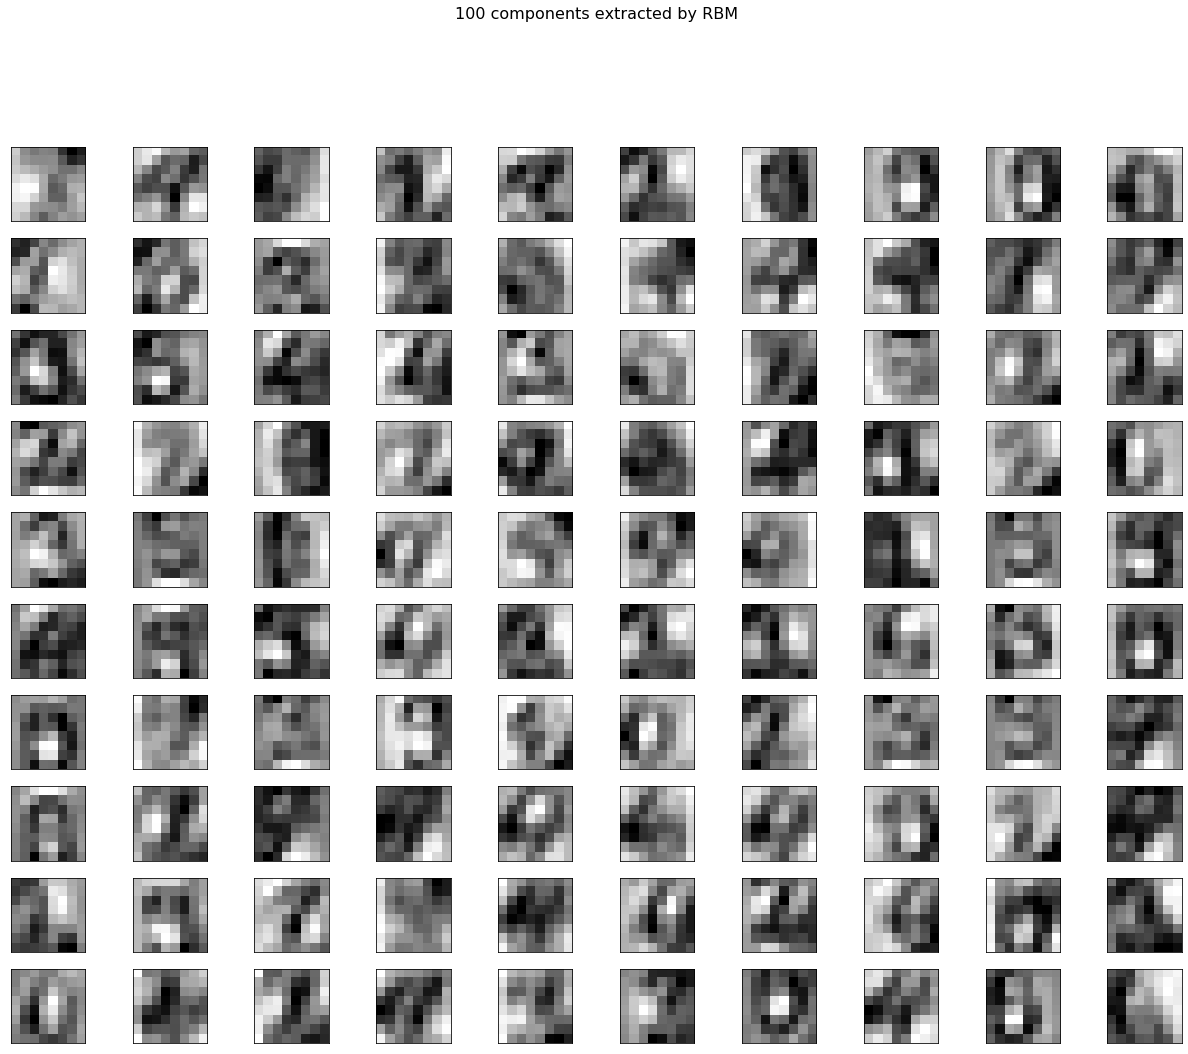

In [17]:
# Plotting

plt.figure(figsize=(20, 15))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# このシリーズを通して、最後に
[@puriketu99氏 機械学習クソ素人の俺がプロダクトをリリースするまでの2ヶ月で覚えたこと](https://qiita.com/puriketu99/items/c519a95c0b16ea63c1ac)